In [1]:
import vqvae2

/home/chenningcong/Desktop/Deeplearning/deep/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Results will be saved in ./results/vqvae_imagenettue_mar_5_10_58_56_2024.pth


In [2]:
def show_image(n_iter, id = 8, clip=False):
    f, axarr = plt.subplots(2, id, figsize=(id*4, 8))
    model.eval()
    scale_img = lambda x : (x+1)/2
    for i in range(0, id):
        data = training_data[i][0]
        axarr[0][i].axis("off")
        axarr[0][i].imshow(scale_img(data.permute((1,2,0)).cpu().detach().numpy()))
        with torch.no_grad():
            _, output, _ = model(data.unsqueeze(0).to(device))
        if clip:
            output = torch.clip(output, min=-1,max=1)
        output = scale_img(output)
        output = output.squeeze(0).permute((1,2,0)).cpu().detach().numpy()
        axarr[1][i].axis("off")
        axarr[1][i].imshow(output)
    f.suptitle("Face plot"+str(n_iter))
    plt.savefig("plot/"+type(model).__name__ + str(n_iter) + ".png")
    plt.show()

In [2]:
import transformers
import numpy as np
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import argparse
import utils
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encodings = torch.tensor(np.load("data/tiny-imagenet/vq-vae-embedding.npy")).cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


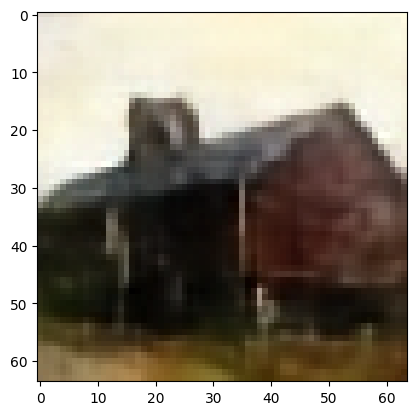

In [5]:
if True:
    e = encodings[0].unsqueeze(0)
    output = vqvae2.model.get_decode(e[:,:8*8].to(device), e[:,8*8:].to(device)).squeeze(0)
    scale_img = lambda x : (x+1)/2
    plt.imshow(scale_img(output.permute((1,2,0)).cpu().detach().numpy()))

In [4]:
from transformers import BertModel, BertConfig
#{"hidden_size": 512, "hidden_act": "gelu", "initializer_range": 0.02, "vocab_size": 30522, "hidden_dropout_prob": 0.1, "num_attention_heads": 8, "type_vocab_size": 2, "max_position_embeddings": 512, "num_hidden_layers": 4, "intermediate_size": 2048, "attention_probs_dropout_prob": 0.1}
# we don't need padding, only masking
mask_token_id = 512
total_tokens = 512 + 1
config = BertConfig(vocab_size=total_tokens,
        hidden_size=256,
        num_hidden_layers=6,
        num_attention_heads=8,
        intermediate_size=512,
        hidden_act="gelu",
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
        max_position_embeddings=320,
        type_vocab_size=2,
        initializer_range=0.02,
        layer_norm_eps=1e-12,
        position_embedding_type="absolute",
        use_cache=True,
        classifier_dropout=None,)

model = transformers.BertForMaskedLM(config)
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

model = transformers.BertForMaskedLM.from_pretrained("bert/checkpoint-67000/").to(device)
get_n_params(model)

3443713

In [8]:
encodings.shape[0]

93270

In [9]:
from transformers import DataCollatorForLanguageModeling

In [10]:
class Tokenizer():
    def __init__(self):
        self.mask_token = mask_token_id
    def get_special_tokens_mask(self, val, already_has_special_tokens):
        return [False for i in val]
    def convert_tokens_to_ids(self, val):
        return val
    def __len__(self):
        return total_tokens
        
data_collator = DataCollatorForLanguageModeling(tokenizer=Tokenizer(),mlm_probability=0.3)

In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __getitem__(self, i):
        return self.data[i]
    def __len__(self):
        return self.data.shape[0]
lm_dataset = CustomDataset(encodings)
val_dataset = CustomDataset(encodings[:50,:])

In [14]:
!rm bert/* -rf
from transformers import TrainingArguments, Trainer
from datasets import load_metric
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    indices = [[i for i, x in enumerate(labels[row]) if x != -100] for row in range(len(labels))]

    labels = [labels[row][indices[row]] for row in range(len(labels))]
    labels = [item for sublist in labels for item in sublist]
    
    predictions = [predictions[row][indices[row]] for row in range(len(predictions))]
    predictions = [item for sublist in predictions for item in sublist]
    
    results = metric.compute(predictions=predictions, references=labels)
    results["eval_accuracy"] = results["accuracy"]
    print(results)
    results.pop("accuracy")

    return results
training_args = TrainingArguments(
    output_dir="bert",
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    num_train_epochs=50,
    weight_decay=0.01,
    logging_steps=10,
    logging_dir='bert/logs',
    per_device_train_batch_size=32,
     
)
class AutoregressiveTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = MSELoss()
        loss = loss_fct(logits.squeeze(), labels.squeeze())
        return (loss, outputs) if return_outputs else loss
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()


/home/chenningcong/Desktop/Deeplearning/deep/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,3.493800,3.248777,0.315192
2,3.455100,3.141201,0.325675
3,3.406000,3.117907,0.336875
4,3.297300,3.081006,0.328038
5,3.309000,3.054117,0.332428
6,3.225200,3.044032,0.330389
7,3.190700,2.924419,0.351241
8,3.210400,2.936027,0.357943
9,3.058600,2.820830,0.371292
10,3.161300,2.872856,0.369627


{'accuracy': 0.31519226728304267, 'eval_accuracy': 0.31519226728304267}
{'accuracy': 0.32567513099556633, 'eval_accuracy': 0.32567513099556633}
{'accuracy': 0.336875, 'eval_accuracy': 0.336875}
{'accuracy': 0.3280379616257479, 'eval_accuracy': 0.3280379616257479}
{'accuracy': 0.33242791475135813, 'eval_accuracy': 0.33242791475135813}
{'accuracy': 0.33038906414300734, 'eval_accuracy': 0.33038906414300734}
{'accuracy': 0.3512405167110929, 'eval_accuracy': 0.3512405167110929}
{'accuracy': 0.3579427623392783, 'eval_accuracy': 0.3579427623392783}
{'accuracy': 0.3712922630159718, 'eval_accuracy': 0.3712922630159718}
{'accuracy': 0.36962692619626925, 'eval_accuracy': 0.36962692619626925}
{'accuracy': 0.3736309154784046, 'eval_accuracy': 0.3736309154784046}
{'accuracy': 0.3447757991847243, 'eval_accuracy': 0.3447757991847243}
{'accuracy': 0.3598659405111018, 'eval_accuracy': 0.3598659405111018}
{'accuracy': 0.3721544715447154, 'eval_accuracy': 0.3721544715447154}
{'accuracy': 0.382161594963273

KeyboardInterrupt: 

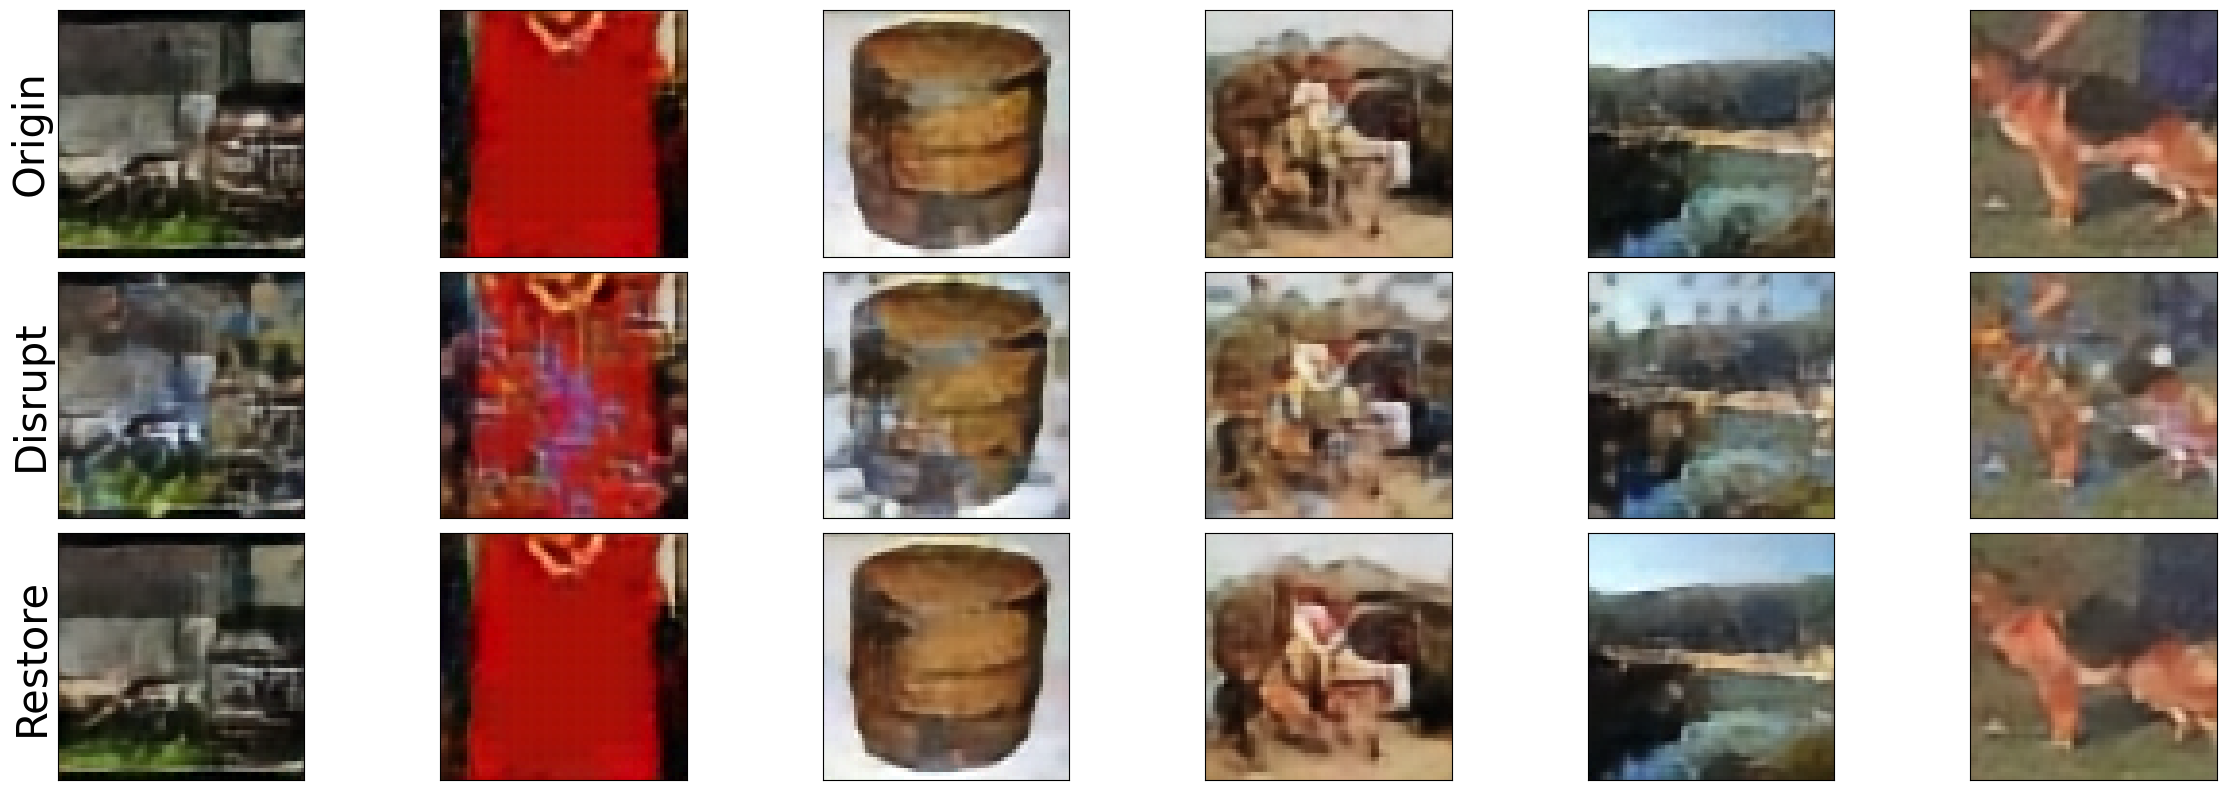

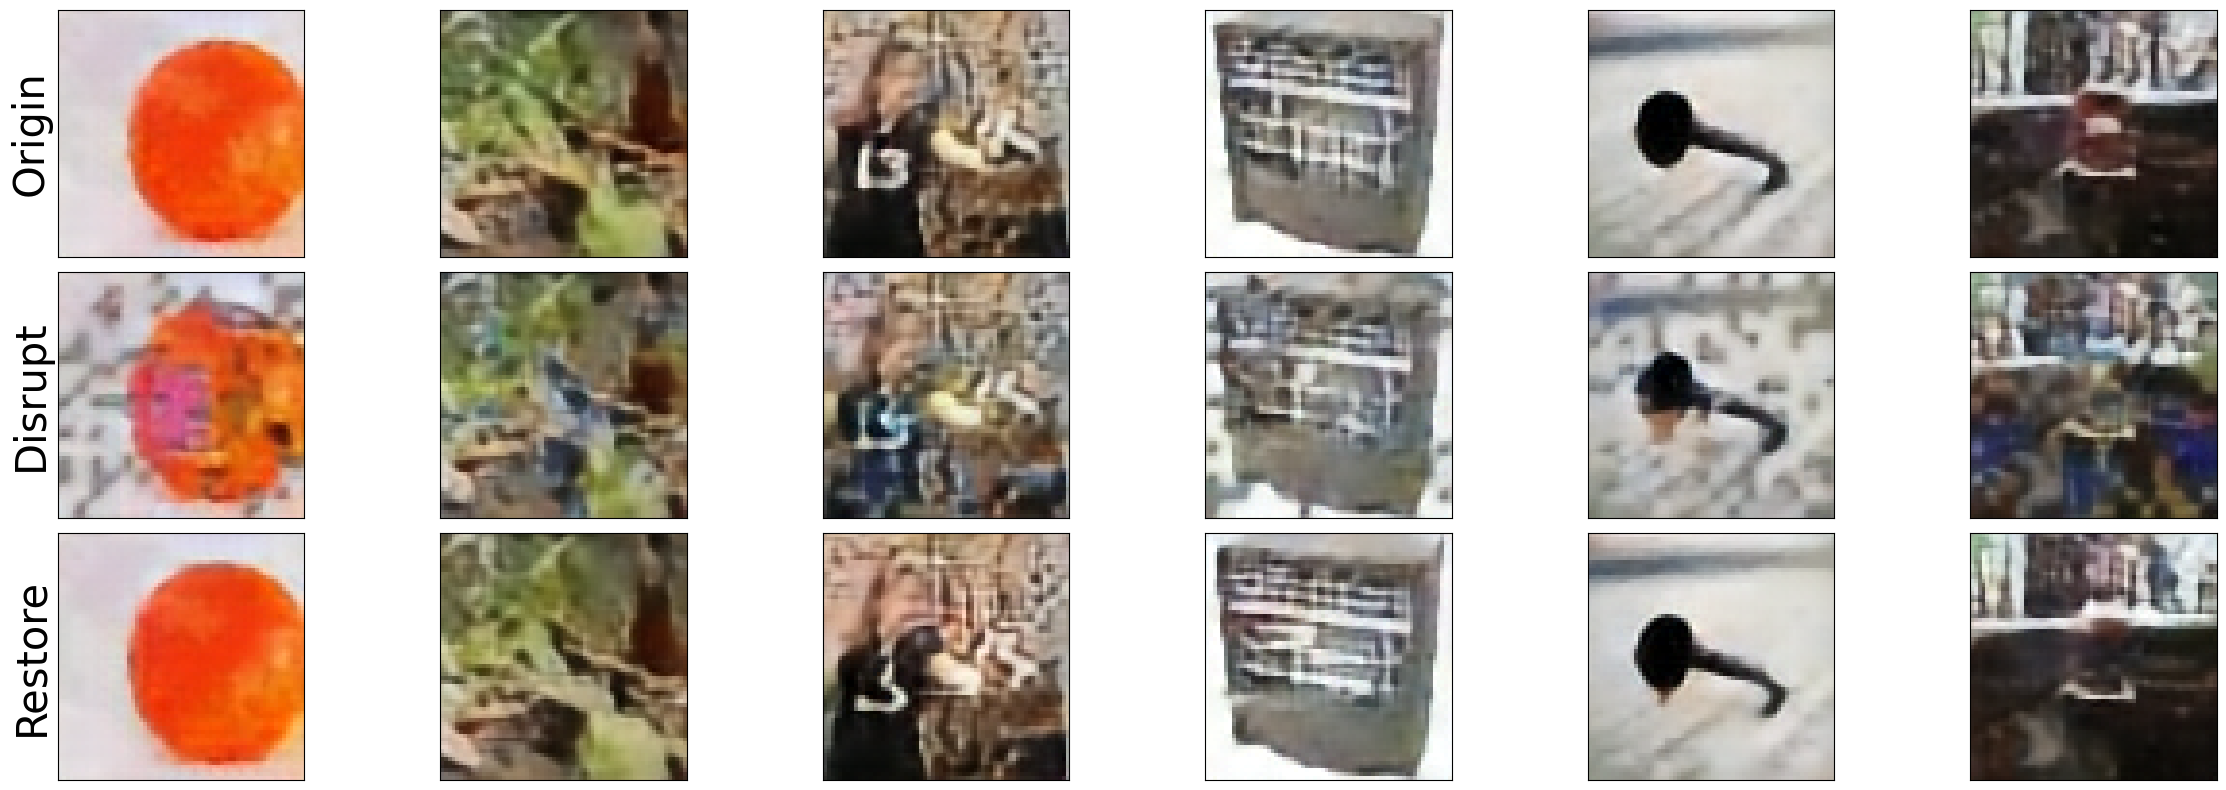

In [107]:
!mkdir commit -p
def get_decoding(ri):
    rti = ri[:,:8*8]
    rbi = ri[:,8*8:]
    data = vqvae2.model.get_decode(rti,rbi).squeeze(0)
    scale_img = lambda x : (torch.clip(x, min=-1,max=1)+1)/2
    return scale_img(data.permute((1,2,0))).cpu().detach().numpy()
def remove_ticks(plt):
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) 
def show_restore_images(id, seed=0):
    import random
    f, axarr = plt.subplots(3, id, figsize=(id*4, 8))
    model.eval()
    random.seed(seed)
    torch.manual_seed(0)
    for index in range(0, id):
        origin = lm_dataset[random.choice(range(len(lm_dataset)))]
        es = data_collator([origin])
        i = es['input_ids'].to(device) 
        l = es['labels'].to(device)

        ooo = origin.unsqueeze(0).to(device)
        remove_ticks(axarr[0][index])
        axarr[0][index].imshow(get_decoding(ooo))
        
        ooo = torch.where(i==512,0,i)
        remove_ticks(axarr[1][index])
        axarr[1][index].imshow(get_decoding(ooo))
        
        
        ri = torch.argmax(model(input_ids=i, labels=l).logits, axis=-1)
        remove_ticks(axarr[2][index])
        axarr[2][index].imshow(get_decoding(ri))
    rows = [row for row in ['Origin', 'Disrupt', 'Restore']]
    for ax, row in zip(axarr[:,0], rows):
        ax.set_ylabel(row, rotation=90, size=30)
    f.tight_layout()
    plt.savefig(f"commit/bert-{seed}.png")
    plt.show()
show_restore_images(6,seed=89)
show_restore_images(6,seed=32)

In [88]:
full_dataset = ImageNet()

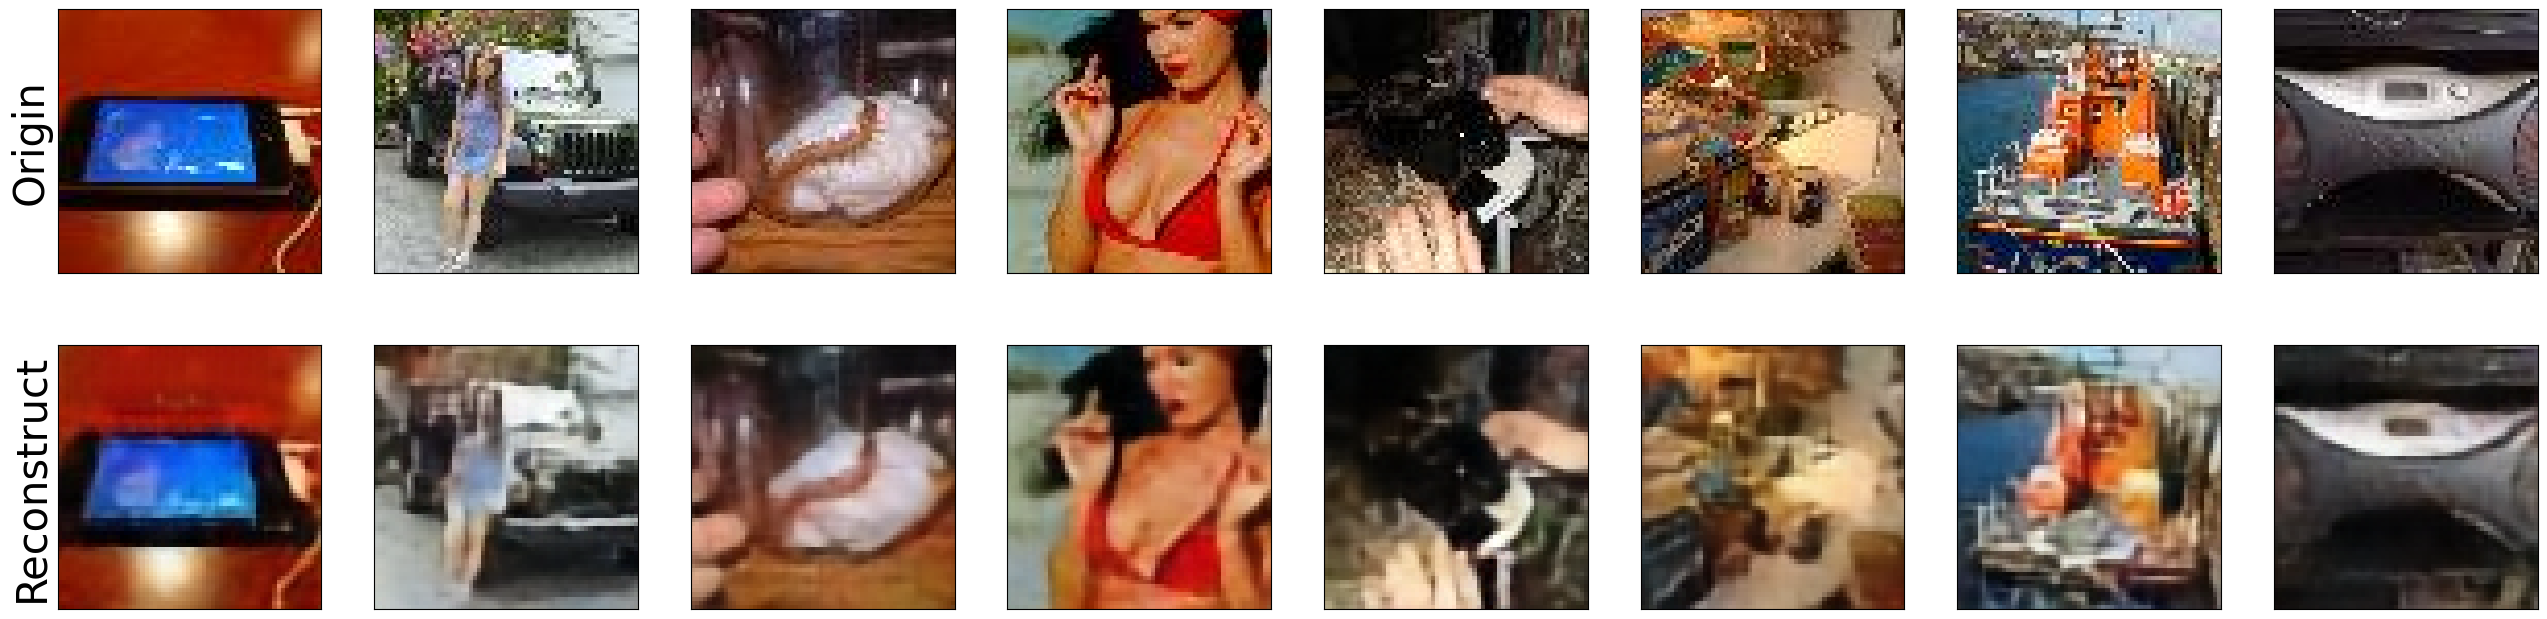

In [109]:
def show_image_random(dataset, id = 8, clip=True, seed=0):
    f, axarr = plt.subplots(2, id, figsize=(id*4, 8))
    model.eval()
    scale_img = lambda x : (x+1)/2
    import random
    random.seed(seed)
    xxx = [random.randrange(len(dataset)) for i in range(id)]
    for i,di in enumerate(xxx):
        data = dataset[di][0]
        remove_ticks(axarr[0][i])
        axarr[0][i].imshow(scale_img(data.permute((1,2,0)).cpu().detach().numpy()))
        with torch.no_grad():
            _, output, _ = vqvae2.model(data.unsqueeze(0).to(device))
        output = torch.clip(output, min=-1,max=1)
        output = scale_img(output)
        output = output.squeeze(0).permute((1,2,0)).cpu().detach().numpy()
        remove_ticks(axarr[1][i])
        axarr[1][i].imshow(output)
    rows = [row for row in ['Origin', 'Reconstruct']]
    for ax, row in zip(axarr[:,0], rows):
        ax.set_ylabel(row, rotation=90, size=30)
    plt.savefig(f"commit/imagenet-{seed}.png")
    plt.show()
    
class InGPUDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.data = (torch.stack([i[0] for i in dataset]).to(device), torch.tensor([i[1] for i in dataset]).to(device))
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, i):
        return self.data[0][i], self.data[1][i]
class ImageNet(torch.utils.data.Dataset):
    def __init__(self):
        self.images = torch.tensor(np.load("data/tiny-imagenet/image.npy")).to(device)
        with torch.no_grad():
            self.images = (2/255)*self.images.permute((0, 3,1,2)) - 1 
        torch.cuda.empty_cache()
        self.labels = torch.tensor(np.load("data/tiny-imagenet/label.npy")).to(device)
    def __len__(self):
        return self.images.shape[0]
    def __getitem__(self, i):
        return self.images[i], self.labels[i]

show_image_random(full_dataset,id = 8, clip=False)